<a href="https://colab.research.google.com/github/Rohit-Singh12/Deep-LEARGNINGS/blob/main/LLM%20Fine%20tuning/LoRA/LoRA_vs_Full_Model_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adding to LoRA vs. Full Model Training

When fine-tuning models, we often choose between **Low-Rank Adaptation (LoRA)** and **Full Model Training** based on efficiency, resource constraints, and intended use.

- **LoRA** updates only a small set of parameters, significantly reducing computational costs while maintaining quality. It is ideal for domain adaptation or adding specific knowledge to large pre-trained models without excessive resource usage.
- **Full Model Training**, on the other hand, modifies all parameters, leading to better generalization but requiring significantly more compute power and data. This approach is necessary when making deep architectural changes or significantly altering a model’s behavior.


In this section, we will learn how to train LLMs on custom dataset using LoRA and QLoRA.
We will use Financial phrase dataset for sentimental Analysis

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.3 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset,get_dataset_config_names

Adding dataset from Kaggle. Here we are using Financial phrase

In [3]:
configs = get_dataset_config_names("financial_phrasebank")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.88k [00:00<?, ?B/s]

financial_phrasebank.py:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

The repository for financial_phrasebank contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/financial_phrasebank.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [4]:
# we will use dataset with senteces_allagree
configs

['sentences_allagree',
 'sentences_75agree',
 'sentences_66agree',
 'sentences_50agree']

In [13]:
from typing import Final

In [51]:
data : Final = load_dataset("financial_phrasebank", "sentences_allagree")

In [52]:
import pandas as pd
df = data['train'].to_pandas()

In [53]:
df.head()

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,"For the last quarter of 2010 , Componenta 's n...",2
2,"In the third quarter of 2010 , net sales incre...",2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2
4,"Operating profit totalled EUR 21.1 mn , up fro...",2


## Base Model: DistilBERT  
In this implementation, we use **DistilBERT (distilbert-base-uncased)** as the base model.  


In [54]:
checkpoint = 'distilbert-base-uncased'#base model

In [55]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [56]:
def tokenize(sentence):
  return tokenizer(
      sentence['sentence'],
      padding="max_length",
      truncation=True,
      max_length=512,
      return_tensors="tf"
  )

Tokenize the sentences for training the model

In [57]:
tokenized_data = data['train'].map(tokenize, batched=True)

## **Tokenization, Input IDs, and Attention Mask in Transformer Models**

Tokenization in Transformer models like **BERT/DistilBERT** converts text into numerical representations for processing. The key components are:

---

### **1. Tokenization Process**
When a sentence is tokenized, it undergoes:
- **Lowercasing** (for uncased models)
- **WordPiece Tokenization**
- **Mapping tokens to unique IDs from the model’s vocabulary**

For example, tokenizing `"Hello world!"`:

$$
\text{Tokens} = [\text{"hello"}, \text{"world"}, \text{"!"}]
$$

Each token is mapped to a unique **input ID**:

$$
\text{Input IDs} = [7592, 2088, 999]
$$

---

### **2. Special Tokens**
BERT-based models use **special tokens** for sentence structure:

| **Token** | **Meaning** | **Example ID** |
|-----------|------------|---------------|
| `[CLS]`   | Start of sentence | 101 |
| `[SEP]`   | End of sentence / separator | 102 |
| `[PAD]`   | Padding for shorter sequences | 0 |
| `[MASK]`  | Masked token for MLM tasks | 103 |

For `"Hello world!"`, tokenizing with special tokens gives:

$$
\text{Input IDs} = [101, 7592, 2088, 999, 102]
$$

Here:
- `101` (`[CLS]`) marks the **start** of the sequence.
- `102` (`[SEP]`) marks the **end** of the sequence.

---

### **3. Attention Mask**
The **attention mask** tells the model which tokens to **attend to** and which to **ignore (padding tokens).**  
- `1` → The token **should be processed** (real words).  
- `0` → The token **should be ignored** (padding).  

For example, if **padding is applied** to match a fixed sequence length (e.g., `max_length=6`):

| Token | `[CLS]` | `Hello` | `world` | `!` | `[SEP]` | `[PAD]` |
|--------|--------|--------|--------|--------|--------|--------|
| Input IDs | 101 | 7592 | 2088 | 999 | 102 | 0 |
| Attention Mask | 1 | 1 | 1 | 1 | 1 | 0 |

Mathematically:

$$
\text{Attention Mask} = [1, 1, 1, 1, 1, 0]
$$

This ensures that the model **processes actual words** while **ignoring padding** during computations.

---

### **4. Subword Tokenization (WordPiece)**
If a word is **not in the vocabulary**, it is split into **subword tokens**.

For `"Transformer models are amazing!"`:

$$
\text{Tokens} = [\text{"transform"}, \text{"##er"}, \text{"models"}, \text{"are"}, \text{"amazing"}, \text{"!"}]
$$

- `"Transformer"` is split into `"transform"` and `"##er"`, where `"##"` means it continues from the previous token.
- This method handles **out-of-vocabulary (OOV) words** efficiently.

---

### **5. Summary**
By understanding **tokenization, input IDs, and attention masks**, we can effectively preprocess text for Transformer models like **BERT and DistilBERT**, ensuring proper encoding of input sequences.



In [58]:
tokenized_data_df = tokenized_data.to_pandas()
tokenized_data_df.head(10)

,sentence,label,input_ids,attention_mask
0,"According to Gran , the company has no plans t...",1,"[101, 2429, 2000, 12604, 1010, 1996, 2194, 203...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"For the last quarter of 2010 , Componenta 's n...",2,"[101, 2005, 1996, 2197, 4284, 1997, 2230, 1010...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"In the third quarter of 2010 , net sales incre...",2,"[101, 1999, 1996, 2353, 4284, 1997, 2230, 1010...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,"[101, 4082, 5618, 3123, 2000, 7327, 2099, 2410...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,"[101, 4082, 5618, 2561, 3709, 7327, 2099, 2538...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
5,Finnish Talentum reports its operating profit ...,2,"[101, 6983, 5848, 2819, 4311, 2049, 4082, 5618...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
6,Clothing retail chain Sepp+ñl+ñ 's sales incre...,2,"[101, 5929, 7027, 4677, 19802, 2361, 1009, 179...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7,Consolidated net sales increased 16 % to reach...,2,"[101, 10495, 5658, 4341, 3445, 2385, 1003, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
8,Foundries division reports its sales increased...,2,"[101, 2179, 5134, 2407, 4311, 2049, 4341, 3445...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9,"HELSINKI ( AFX ) - Shares closed higher , led ...",2,"[101, 12331, 1006, 21358, 2595, 1007, 1011, 66...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [59]:
#splitting the data with 20% test data and 80% training data
training_data = tokenized_data.train_test_split(test_size=0.2)

In [60]:
training_data

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1811
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 453
    })
})

In [61]:
train_data = training_data['train']
test_data = training_data['test']

In [62]:
len(train_data), len(test_data)

(1811, 453)

In [63]:
#Further splitting test data into validation and test data
test_data = test_data.train_test_split(test_size=0.5)
test_data

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 226
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 227
    })
})

In [64]:
test_data, val_data = test_data['test'], test_data['train']
test_data, val_data

(Dataset({
     features: ['sentence', 'label', 'input_ids', 'attention_mask'],
     num_rows: 227
 }),
 Dataset({
     features: ['sentence', 'label', 'input_ids', 'attention_mask'],
     num_rows: 226
 }))

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

In [66]:
df_train = train_data.to_pandas()
df_test = test_data.to_pandas()
df_val = val_data.to_pandas()

In [67]:
len(val_data)

226

In [68]:
df_train.head(10)

,sentence,label,input_ids,attention_mask
0,LEED is an internationally recognized green bu...,1,"[101, 3389, 2094, 2003, 2019, 7587, 3858, 2665...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,Finnish silicon wafer technology company Okmet...,2,"[101, 6983, 13773, 11333, 7512, 2974, 2194, 79...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,The Company turnover amounted to MEUR 27.9 in ...,1,"[101, 1996, 2194, 20991, 18779, 2000, 2033, 31...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,The front surfaces of these valve plates are d...,1,"[101, 1996, 2392, 9972, 1997, 2122, 10764, 776...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,The value of the contract is EUR 25mn .,1,"[101, 1996, 3643, 1997, 1996, 3206, 2003, 7327...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."
5,Cash Flow from Operations for the most recent ...,0,"[101, 5356, 4834, 2013, 3136, 2005, 1996, 2087...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
6,Mr Jortikka is president of the base metal div...,1,"[101, 2720, 8183, 28228, 15714, 2003, 2343, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7,Diluted EPS rose to EUR3 .68 from EUR0 .50 .,2,"[101, 29454, 12926, 20383, 3123, 2000, 7327, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
8,Finnish Metso Paper has been awarded a contrac...,2,"[101, 6983, 15253, 2080, 3259, 2038, 2042, 301...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9,The total value of the contract is some EUR 8 ...,1,"[101, 1996, 2561, 3643, 1997, 1996, 3206, 2003...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [69]:
df_train['type'] = 'train'
df_test['type'] = 'test'
df_val['type'] = 'val'

In [70]:
df_merged = pd.concat([df_train, df_test, df_val])

In [71]:
df_merged.columns

Index(['sentence', 'label', 'input_ids', 'attention_mask', 'type'], dtype='object')

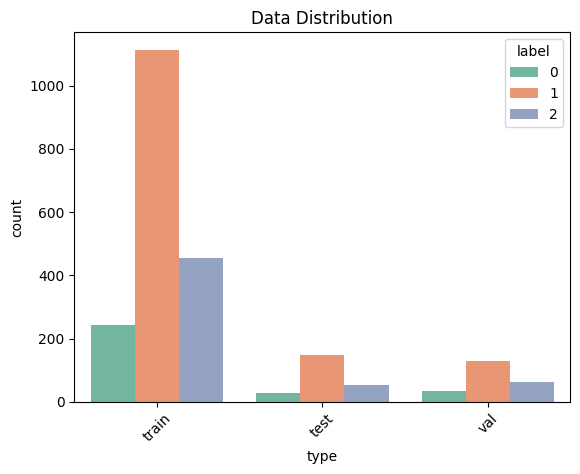

In [72]:
sns.countplot(data=df_merged, x='type', hue='label', palette='Set2')
plt.title("Data Distribution")
plt.xticks(rotation=45)
plt.show()

In [73]:
model_full = TFAutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                                  num_labels=3)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [74]:
import tensorflow as tf
from transformers import DataCollatorWithPadding

## **Function: `to_tf_data`**
The function **`to_tf_data(data)`** converts a dataset into a **TensorFlow-compatible format** (`tf.data.Dataset`).  
This is useful for training transformer models efficiently in **TensorFlow/Keras**.

---

### **1. Function Breakdown**
The function takes `data` (a dataset) and calls `.to_tf_dataset()`, specifying:
- **`columns=["input_ids", "attention_mask"]`** → Selects model input features.
- **`label_cols=['label']`** → Specifies the label column for supervised learning.
- **`shuffle=True`** → Randomizes the dataset for better training performance.
- **`batch_size=8`** → Processes **8 samples per batch** for efficient training.
- **`collate_fn=DataCollatorWithPadding(...)`** → Ensures all sequences in a batch have the **same length** by applying **dynamic padding**.

---

### **2. What is `DataCollatorWithPadding`?**
Since input sentences have **varying lengths**, this function:
- **Dynamically pads** sequences in each batch to the longest sequence in that batch.
- **Avoids excessive padding**, improving efficiency.
- **Maintains `input_ids` and `attention_mask` alignment**.

Mathematically, given sequences of different lengths:

$$
\text{Batch} =
\begin{bmatrix}
[101, 7592, 2088, 102] \\
[101, 2023, 2003, 1037, 2742, 102] \\
[101, 2129, 2024, 2017, 102]
\end{bmatrix}
$$

The **collator pads them dynamically**:

$$
\text{Padded Batch} =
\begin{bmatrix}
[101, 7592, 2088, 102, 0, 0] \\
[101, 2023, 2003, 1037, 2742, 102] \\
[101, 2129, 2024, 2017, 102, 0]
\end{bmatrix}
$$

Here:
- `0` represents the `[PAD]` token.
- The **attention mask** ensures only non-padding tokens are processed.

---

### **3. Why Convert to `tf.data.Dataset`?**
TensorFlow’s `tf.data.Dataset` provides:
- **Optimized pipeline** for batching, shuffling, and prefetching.
- **Improved memory efficiency** compared to NumPy/Pandas.
- **Compatibility with Keras models** (`model.fit()` can use it directly).

**Final Usage Example in Training:**
```python
tf_dataset = to_tf_data(dataset)
model.fit(tf_dataset, epochs=3)


In [75]:
def to_tf_data(data):
  return data.to_tf_dataset(
      columns=["input_ids", "attention_mask"],
      label_cols=['label'],
      shuffle=True,
      batch_size=8,
      collate_fn=DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
  )

In [76]:
len(train_data)

1811

In [77]:
train_data = to_tf_data(train_data)

/usr/local/lib/python3.11/dist-packages/datasets/arrow_dataset.py:405: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [80]:
 #Due to batching now the training data has 227 bactes with each
 # batch containing 8 dataset
len(train_data)

227

In [81]:
#Converting validation data to tensor
val_data = to_tf_data(val_data)

## **Training Transformer Model in TensorFlow**

After preprocessing and converting data to `tf.data.Dataset`, we proceed with training the model. Below are the key steps:

---

### **1. Defining the Number of Training Steps**
The total number of training steps is determined as:

$$
\text{Total Steps} = \frac{\text{Dataset Size}}{\text{Batch Size}} \times \text{Epochs}
$$

For example, if:
- Dataset size = **1811**
- Batch size = **8**
- Epochs = **3**

Then:
$$
\text{Total Steps} = \frac{1811}{8} \times 3 = 678
$$

## **Training Transformer Models with Polynomial Decay in TensorFlow**

---

### **1. Learning Rate Scheduling with Polynomial Decay**

Polynomial decay **reduces the learning rate over time** to stabilize training. The learning rate at step \( t \) is given by:

$$
LR_t = LR_{\text{init}} \times \left(1 - \frac{t}{T}\right)^p
$$




In [82]:
num_train_steps = len(train_data)*3
lr_schedules = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=5e-5,
    decay_steps=num_train_steps,
    end_learning_rate=0.0
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedules)

In [83]:
model_full.compile(optimizer=optimizer,
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

In [84]:
model_full.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_39 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66955779 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [85]:
model_full.fit(train_data,
         epochs=10,
         validation_data=val_data)

Epoch 1/10
227/227 [==============================] - 134s 488ms/step - loss: 0.3149 - accuracy: 0.8857 - val_loss: 0.1274 - val_accuracy: 0.9469
Epoch 2/10
227/227 [==============================] - 109s 480ms/step - loss: 0.0562 - accuracy: 0.9834 - val_loss: 0.1227 - val_accuracy: 0.9646
Epoch 3/10
227/227 [==============================] - 109s 481ms/step - loss: 0.0338 - accuracy: 0.9906 - val_loss: 0.0919 - val_accuracy: 0.9690
Epoch 4/10
227/227 [==============================] - 109s 480ms/step - loss: 0.0178 - accuracy: 0.9961 - val_loss: 0.0919 - val_accuracy: 0.9690
Epoch 5/10
227/227 [==============================] - 110s 483ms/step - loss: 0.0169 - accuracy: 0.9961 - val_loss: 0.0919 - val_accuracy: 0.9690
Epoch 6/10
227/227 [==============================] - 109s 481ms/step - loss: 0.0196 - accuracy: 0.9956 - val_loss: 0.0919 - val_accuracy: 0.9690
Epoch 7/10
227/227 [==============================] - 110s 483ms/step - loss: 0.0180 - accuracy: 0.9967 - val_loss: 0.0919 -

## **Using LoRA for Efficient Transformer Training**

LoRA (**Low-Rank Adaptation**) is an advanced fine-tuning technique that **reduces memory usage and accelerates training** by modifying only a small number of parameters in pre-trained models.

---

### **1. Loading a Pre-Trained Transformer Model**
We begin by loading a **pre-trained Transformer** for sequence classification:

In [142]:
from transformers import AutoModelForSequenceClassification
#training using LoRA
model_lora = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                                num_labels=3)
# model_lora.load_weights("/content/drive/My Drive/classifier_head_weights.h5", by_name=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [143]:
from peft import LoraConfig,  get_peft_model

## **Configuring LoRA for Efficient Fine-Tuning**

LoRA (**Low-Rank Adaptation**) fine-tunes only **small low-rank matrices** in specific layers instead of updating all model parameters. Below, we define a **LoRA configuration** using `LoraConfig`:


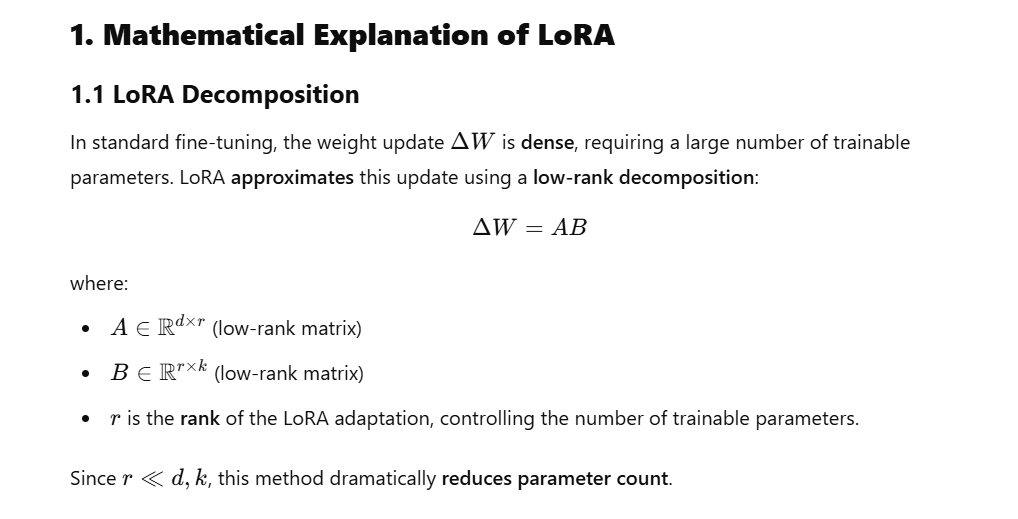

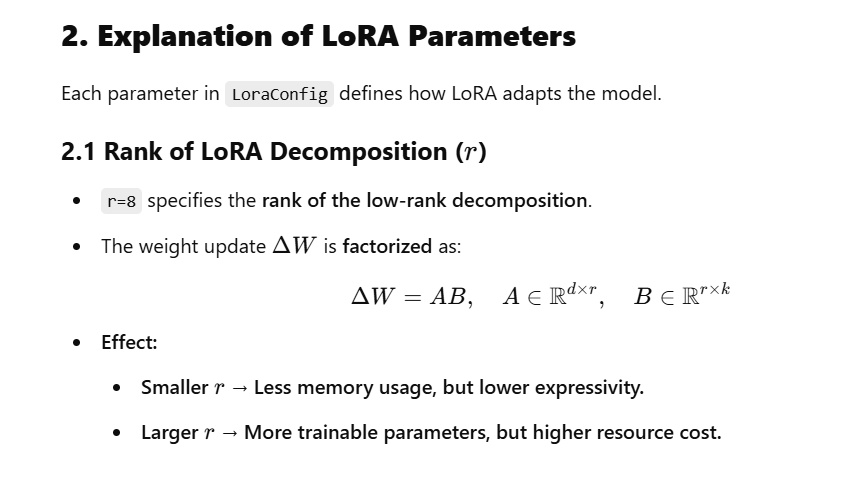

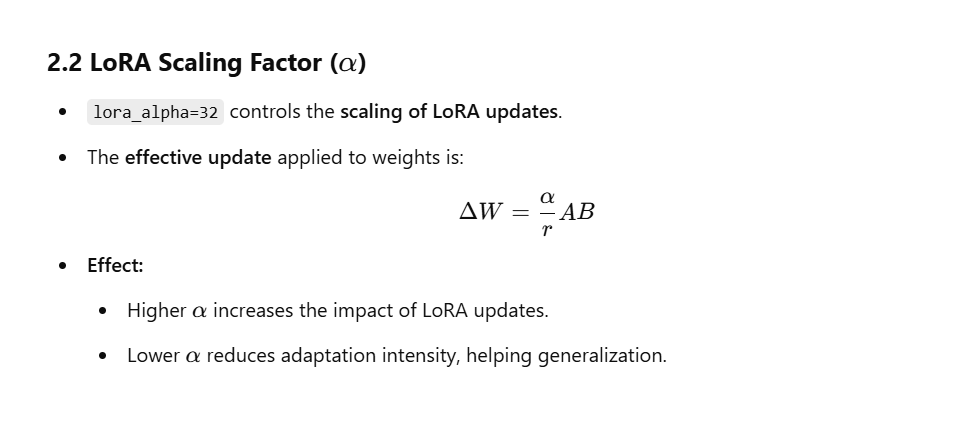

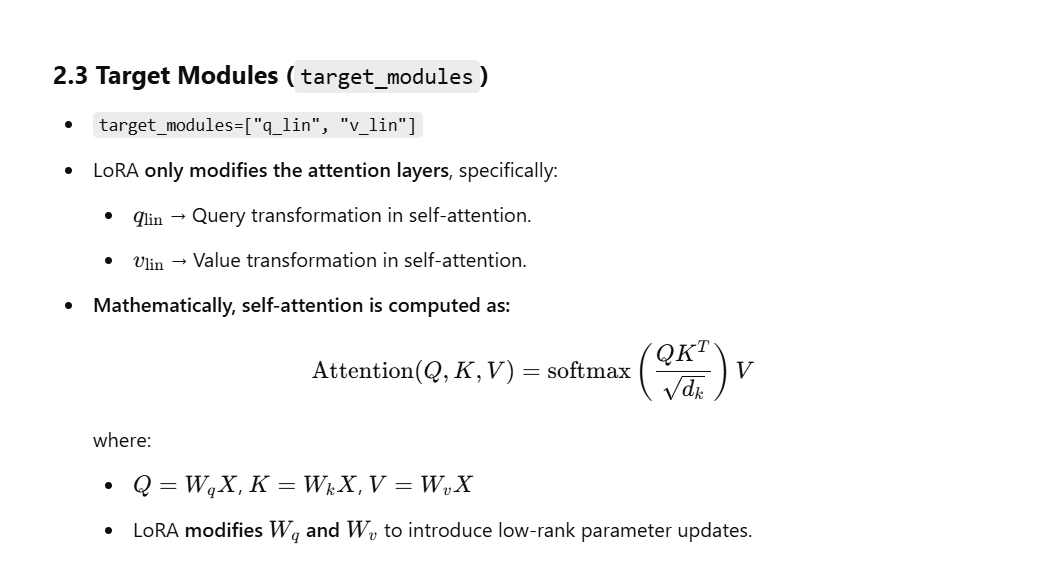

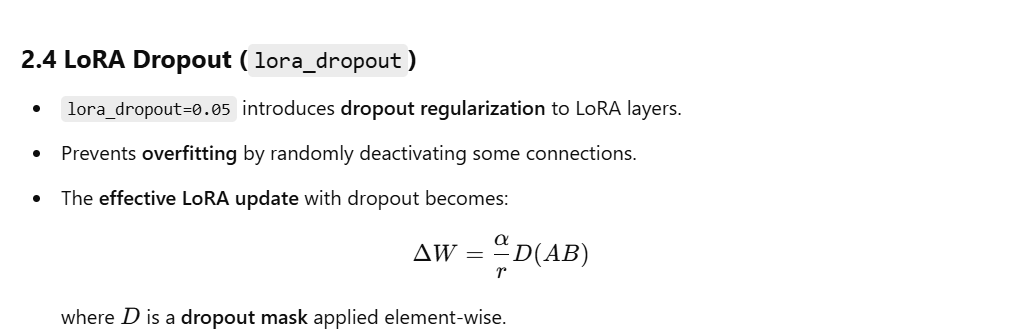

In [144]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_lin", "v_lin"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS"
)

In [145]:
# Apply LoRA
model_lora = get_peft_model(model_lora, lora_config)

# Print trainable parameters
model_lora.print_trainable_parameters() #number of training parameters is only
# 7 lakh


trainable params: 740,355 || all params: 67,696,134 || trainable%: 1.0936


In [146]:
data

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2264
    })
})

In [147]:
def tokenize_function(data):
  return tokenizer(
      data['sentence'],
      truncation=True,
      padding='max_length',
      max_length=512
  )
torch_tokenized_data = data['train'].map(tokenize_function, batched=True)
torch_tokenized_data

Dataset({
    features: ['sentence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2264
})

In [148]:
import torch
torch_tokenized_data.set_format('torch')

In [149]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./lora_finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_steps=10,
    report_to="none",
    logging_dir="./logs"
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [150]:
torch_tokenized_data

Dataset({
    features: ['sentence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2264
})

In [151]:
torch_train = torch_tokenized_data.train_test_split(test_size=0.2)
torch_train

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1811
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 453
    })
})

In [152]:
torch_train, torch_test = torch_train['train'], torch_train['test']
torch_test = torch_test.train_test_split(test_size=0.5)
torch_test

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 226
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 227
    })
})

In [153]:
torch_test, torch_eval = torch_test['test'], torch_test['train']

In [154]:
from transformers import Trainer, DataCollatorWithPadding
trainer = Trainer(
    model=model_lora,
    args=training_args,
    train_dataset=torch_train,
    eval_dataset=torch_eval,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer)
)

<ipython-input-154-120f9dc0b86e>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [155]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.547400,0.539941
2,0.328200,0.321511
3,0.260300,0.242964
4,0.250700,0.194561
5,0.156300,0.182013
6,0.114600,0.175507
7,0.119700,0.173368
8,0.151700,0.174257
9,0.079600,0.172372
10,0.106600,0.168701


TrainOutput(global_step=1140, training_loss=0.2461357103105177, metrics={'train_runtime': 705.6571, 'train_samples_per_second': 25.664, 'train_steps_per_second': 1.616, 'total_flos': 2440216222986240.0, 'train_loss': 0.2461357103105177, 'epoch': 10.0})

In [156]:
len(torch_test), len(test_data)

(227, 227)

In [157]:
model_lora.eval()

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): DistilBertForSequenceClassification(
      (distilbert): DistilBertModel(
        (embeddings): Embeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (transformer): Transformer(
          (layer): ModuleList(
            (0-5): 6 x TransformerBlock(
              (attention): DistilBertSdpaAttention(
                (dropout): Dropout(p=0.1, inplace=False)
                (q_lin): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=7

# Checking the Performance of the two Models

In [172]:
from sklearn.metrics import confusion_matrix, classification_report

In [158]:
import numpy as np
# Convert Hugging Face Dataset to dictionary format
test_data_dict = test_data.to_dict()
torch_test_dict = torch_test.to_dict()

# Extract input IDs and attention masks
test_texts = test_data_dict["sentence"]
torch_test_texts = torch_test_dict["sentence"]

# Extract true labels
true_labels_tf = np.array(test_data_dict["label"])
true_labels_pt = np.array(torch_test_dict["label"])

In [161]:
len(test_texts), len(torch_test_texts)

(227, 227)

In [164]:
# Tokenize the inputs
tf_inputs = tokenizer(test_texts, padding=True, truncation=True, max_length=512, return_tensors="tf")
pt_inputs = tokenizer(torch_test_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

In [165]:
tf_inputs_tensors = {key: tf.convert_to_tensor(val.numpy()) for key, val in tf_inputs.items()}
tf_preds = model_full(tf_inputs_tensors).logits

In [166]:
tf_preds = np.argmax(tf_preds, axis=-1)

In [168]:
tf_preds, len(tf_preds)

(array([0, 2, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 2, 0, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1, 0, 2, 2, 0, 0, 1, 1, 1, 0,
        1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 2, 2, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 0, 1, 1, 0, 1,
        1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 2, 1, 1, 0, 0, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1,
        1, 2, 1, 1, 2, 1, 1, 2, 0, 1, 1, 2, 1, 2, 2, 1, 2, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 1, 2, 2, 1, 1, 2, 2,
        1, 2, 1, 2, 1, 1, 0]),
 227)

In [169]:
pt_inputs = {key: val.to('cuda') for key, val in pt_inputs.items()}
with torch.no_grad():
  lora_preds = model_lora(**pt_inputs).logits
  lora_preds = torch.argmax(lora_preds, dim=-1).cpu().numpy()

In [170]:
lora_preds, len(lora_preds)

(array([1, 1, 1, 2, 2, 0, 1, 0, 1, 1, 1, 0, 1, 2, 0, 0, 1, 0, 1, 1, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 2, 1, 1, 2, 1, 1, 1, 1, 2, 0,
        2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1,
        1, 1, 1, 2, 1, 1, 2, 1, 0, 2, 0, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2,
        1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0,
        1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1,
        0, 1, 2, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2,
        2, 0, 1, 1, 1, 1, 0, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 2, 0, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1, 0, 0, 0, 2, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 2, 2, 0,
        2, 1, 1, 1, 1, 2, 1]),
 227)

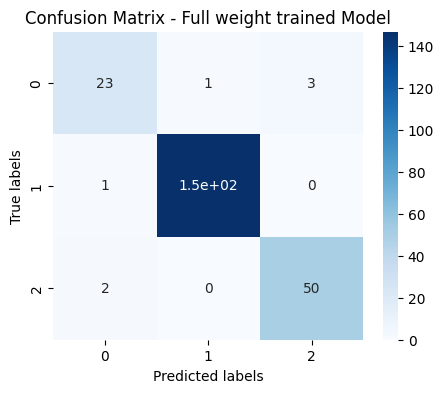

In [173]:
cf_matrix_full = confusion_matrix(true_labels_tf, tf_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cf_matrix_full, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title("Confusion Matrix - Full weight trained Model")
plt.show()

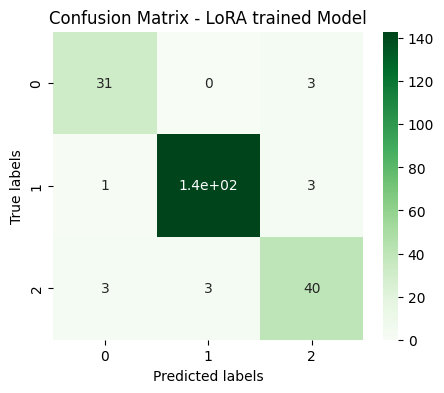

In [174]:
cf_matrix_lora = confusion_matrix(true_labels_pt, lora_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cf_matrix_lora, annot=True, cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title("Confusion Matrix - LoRA trained Model")
plt.show()

In [176]:
from sklearn.metrics import accuracy_score
full_model_accuracy = accuracy_score(true_labels_tf, tf_preds)
lora_accuracy = accuracy_score(true_labels_pt, lora_preds)
print(full_model_accuracy, lora_accuracy)

0.9691629955947136 0.9427312775330396


The performance of the LoRA trained model is almost same as full model training but with lesser resources